In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import pascal3d
import numpy as np
import scipy
import matplotlib.pyplot as plt
from skimage import transform

In [2]:
data_type = 'all'
dataset = pascal3d.dataset.Pascal3DDataset(data_type, generate=False)

# dataset.create_tfrecords()

Shape
(324, 500, 3)
Jittered Shape
(408, 479, 3)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<IPython.core.display.Javascript object>


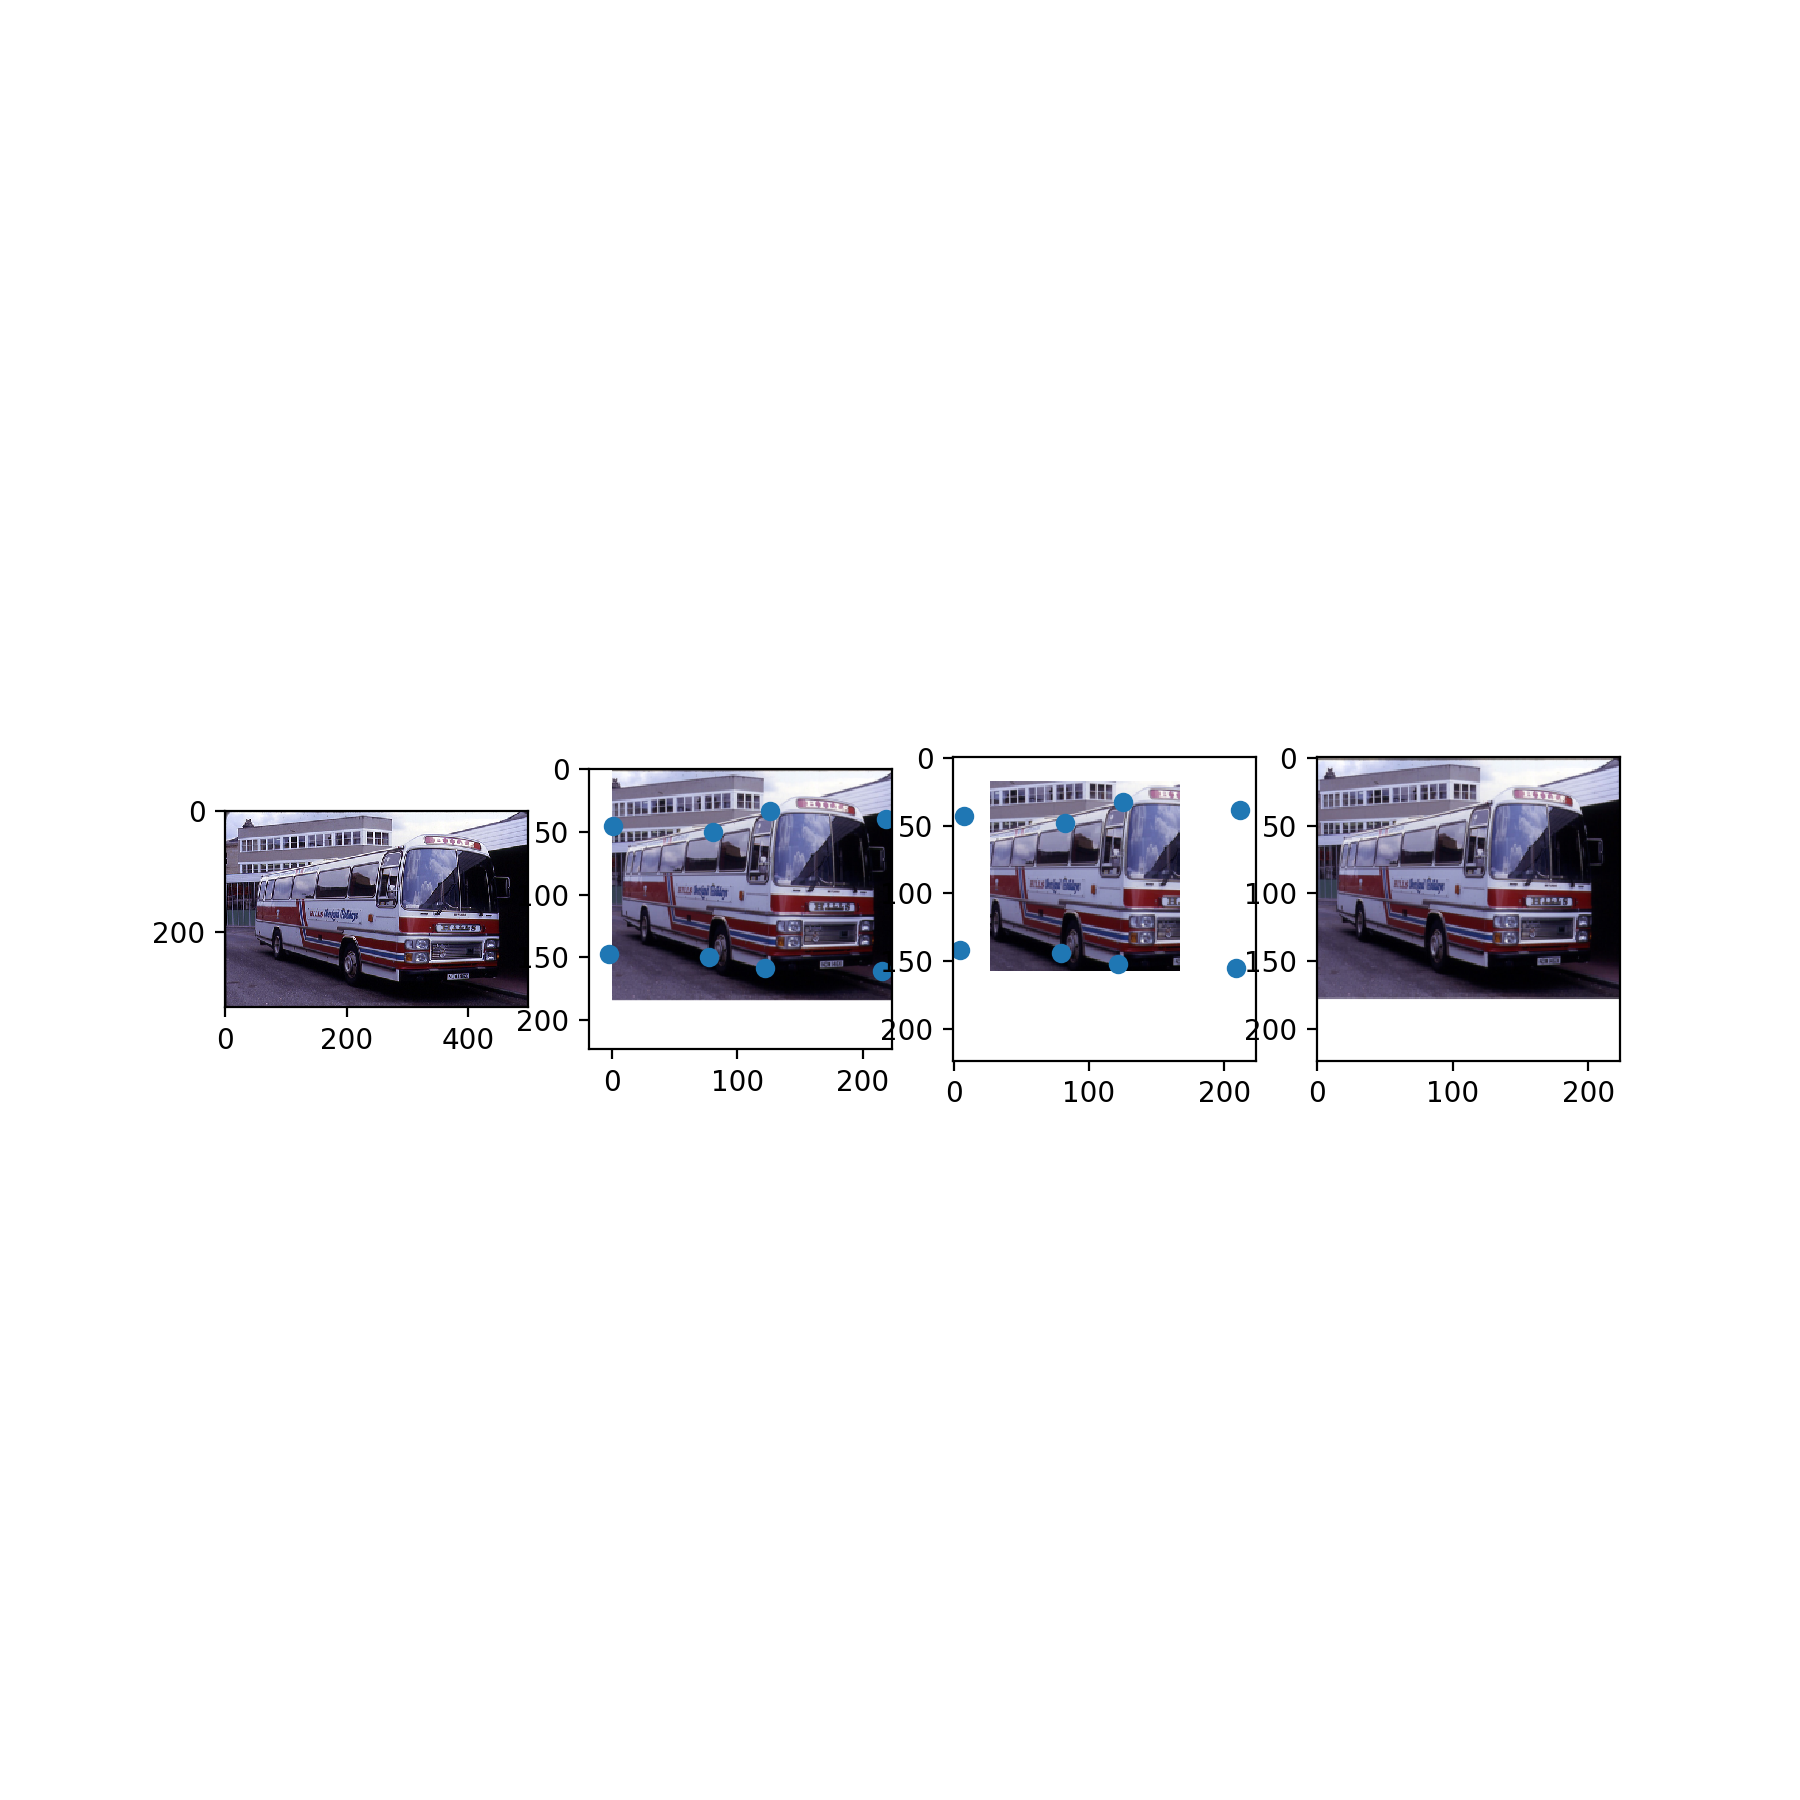

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:71: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [14]:


def random_crop(image, crop_size=(180, 180)):
    h, w, _ = image.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])

    bottom = top + crop_size[0]
    right = left + crop_size[1]

    new_image = np.zeros((224,224,3), dtype=np.uint8)
    new_image.fill(255)
    image_section = image[top:bottom, left:right, :]

    new_image[top:bottom, left:right, :] = image_section
    return new_image, image_section


# dataset.create_tfrecords()
data = dataset.get_data(0,'n02924116_78759')
objects = data['objects']

for counter, (cls, obj) in enumerate(objects):
    img = data['img']
    class_cads = data['class_cads']
    virtual_control_points_2d, bbox_3d_dims = dataset._get_real_domain_output_vector(cls, class_cads,obj)
    bbox = obj['bbox']
    print("Shape")
    print(img.shape)
    
    x_offset = y_offset = 16
    bbox_x1, bbox_y1, bbox_x2, bbox_y2 = bbox
    jittered_bbox = (bbox_x1-x_offset, bbox_y1-y_offset, bbox_x2 + x_offset, bbox_y2 + y_offset)
    jittered_img, jittered_square_bbox= dataset._crop_object_from_img(img, jittered_bbox)
    j_h, j_w, _ = jittered_img.shape
    print("Jittered Shape")
    print(jittered_img.shape)
    crop_dims = 5*(224 //8)

    jittered_img = scipy.misc.imresize(jittered_img, (224,224))
    j_nvcp = dataset._normalize_2d_control_points(virtual_control_points_2d, jittered_square_bbox)
    jittered_ov = np.append(j_nvcp, bbox_3d_dims)

    cropped_img, square_bbox= dataset._crop_object_from_img(img, bbox)
    bbox_x1, bbox_y1, bbox_x2, bbox_y2 = square_bbox
    normalized_virtual_control_points = dataset._normalize_2d_control_points(virtual_control_points_2d, square_bbox)
    resized_img = scipy.misc.imresize(cropped_img, (224,224))
    output_vector = np.append(normalized_virtual_control_points, bbox_3d_dims).astype(np.float)
    object_img = resized_img

    fig = plt.figure(figsize=(9,9))
    ax = plt.subplot(1, 4, 1)
    ax1 = plt.subplot(1, 4, 2)
    ax2 = plt.subplot(1, 4, 3)
    ax3 = plt.subplot(1, 4, 4)
    
    ax.imshow(img)
    ax1.imshow(object_img)
    virtual_control_points = np.array(output_vector[:16]).reshape(8,2) * 224
    ax1.scatter(virtual_control_points[:, 0], virtual_control_points[:, 1])
    
    ax3.imshow(jittered_img)
    
    r_crop, image_section = random_crop(jittered_img, crop_size=(crop_dims, crop_dims))
    ax2.imshow(r_crop)
    
    j_nvcp = j_nvcp.reshape(8, 2)*224
    ax2.scatter(j_nvcp[:, 0] , j_nvcp[:, 1])
    plt.show()
    
    scipy.misc.imsave('save_test.jpg', r_crop)